<a href="https://colab.research.google.com/github/Siddharth-Singh-2004/CU-BEMS_multi-series_forecasting/blob/main/CU_BEMS_multi_time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import math

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
old_df=pd.read_csv('/content/drive/MyDrive/2018Floor1.csv')

In [56]:
old_data = {}

In [57]:
for columns in old_df.columns:
  old_data[columns] = []

In [58]:
old_data

{'Date': [],
 'z1_Light(kW)': [],
 'z1_Plug(kW)': [],
 'z2_AC1(kW)': [],
 'z2_AC2(kW)': [],
 'z2_AC3(kW)': [],
 'z2_AC4(kW)': [],
 'z2_Light(kW)': [],
 'z2_Plug(kW)': [],
 'z3_Light(kW)': [],
 'z3_Plug(kW)': [],
 'z4_Light(kW)': []}

In [59]:
for index, row in old_df.iterrows():
  if index%60 == 0:
    for columns in old_df.columns:
      old_data[columns].append(row[columns])

In [60]:
df = pd.DataFrame(old_data)

In [61]:
df['Date']=pd.to_datetime(df['Date'])

In [62]:
df.head()

,Date,z1_Light(kW),z1_Plug(kW),z2_AC1(kW),z2_AC2(kW),z2_AC3(kW),z2_AC4(kW),z2_Light(kW),z2_Plug(kW),z3_Light(kW),z3_Plug(kW),z4_Light(kW)
0,2018-07-01 00:00:00,12.94,18.56,45.24,0.01,0.01,0.00,13.76,17.64,10.92,0.89,35.76
1,2018-07-01 01:00:00,13.05,19.31,45.89,0.01,0.01,0.01,13.87,15.64,11.01,0.72,35.96
2,2018-07-01 02:00:00,13.12,19.36,45.91,0.02,0.01,0.00,13.96,17.27,11.02,0.73,36.04
3,2018-07-01 03:00:00,12.86,19.08,45.51,0.01,0.01,0.01,13.67,17.12,10.88,0.71,35.63
4,2018-07-01 04:00:00,12.91,18.01,45.47,0.02,0.01,0.00,13.71,10.29,10.95,0.72,35.70


In [63]:
df.tail()

,Date,z1_Light(kW),z1_Plug(kW),z2_AC1(kW),z2_AC2(kW),z2_AC3(kW),z2_AC4(kW),z2_Light(kW),z2_Plug(kW),z3_Light(kW),z3_Plug(kW),z4_Light(kW)
4411,2018-12-31 19:00:00,0.00,0.05,2.32,36.00,0.00,0.02,17.59,17.53,10.08,0.38,24.80
4412,2018-12-31 20:00:00,0.01,0.74,2.30,35.11,0.01,0.02,17.09,9.54,9.93,0.37,24.59
4413,2018-12-31 21:00:00,0.03,0.68,2.31,34.77,0.00,0.02,17.34,9.56,10.01,0.39,14.92
4414,2018-12-31 22:00:00,0.01,0.68,20.21,34.63,0.01,0.02,17.24,18.38,10.00,0.39,24.79
4415,2018-12-31 23:00:00,0.01,0.69,33.86,1.35,0.01,0.00,17.54,19.07,10.06,0.37,14.56


In [64]:
def clean(column):
  return column.dropna().to_numpy()

In [65]:
data = {}

In [66]:
for column in df.columns:
  if column == 'Date':
    data[column] = df[column]
  else:
    data[column] = clean(df[column])

In [67]:
for column in data:
  print(f'{column}: {len(df[column])}')

Date: 4416
z1_Light(kW): 4416
z1_Plug(kW): 4416
z2_AC1(kW): 4416
z2_AC2(kW): 4416
z2_AC3(kW): 4416
z2_AC4(kW): 4416
z2_Light(kW): 4416
z2_Plug(kW): 4416
z3_Light(kW): 4416
z3_Plug(kW): 4416
z4_Light(kW): 4416


In [68]:
# Normalizing
for column in data:
  max = data[column].max()
  min = data[column].min()
  data[column] = (data[column] - min)/(max - min)

In [69]:
# Custom Dataset
class TimeSeriesDataset(Dataset):

  def __init__(self, data, sequence_length):
    self.data = data
    self.sequence_length = sequence_length

  def __len__(self):
    return len(self.data) - self.sequence_length

  def __getitem__(self, idx):
    x = self.data[idx:idx+self.sequence_length]
    y = self.data[idx+self.sequence_length]
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)



In [70]:
train_size = int(len(data['Date']) * 0.8)
test_size = len(data['Date']) - train_size
number_of_hours_in_a_day = 24

In [71]:
dataset = {}
for column in data:
  dataset[column] = TimeSeriesDataset(data[column][:train_size], sequence_length=number_of_hours_in_a_day)

dataset

{'Date': <__main__.TimeSeriesDataset at 0x790cf827c040>,
 'z1_Light(kW)': <__main__.TimeSeriesDataset at 0x790cf827e9e0>,
 'z1_Plug(kW)': <__main__.TimeSeriesDataset at 0x790cf827d4b0>,
 'z2_AC1(kW)': <__main__.TimeSeriesDataset at 0x790cf827f130>,
 'z2_AC2(kW)': <__main__.TimeSeriesDataset at 0x790cf827d180>,
 'z2_AC3(kW)': <__main__.TimeSeriesDataset at 0x790cf829e560>,
 'z2_AC4(kW)': <__main__.TimeSeriesDataset at 0x790cf829da20>,
 'z2_Light(kW)': <__main__.TimeSeriesDataset at 0x790cf829ee00>,
 'z2_Plug(kW)': <__main__.TimeSeriesDataset at 0x790cf829f100>,
 'z3_Light(kW)': <__main__.TimeSeriesDataset at 0x790cf829c4c0>,
 'z3_Plug(kW)': <__main__.TimeSeriesDataset at 0x790cf829d660>,
 'z4_Light(kW)': <__main__.TimeSeriesDataset at 0x790cf829e380>}

In [72]:
dataloader = {}
for column in dataset:
  dataloader[column] = DataLoader(dataset[column], batch_size=32, shuffle=True)
dataloader

{'Date': <torch.utils.data.dataloader.DataLoader at 0x790cf827f310>,
 'z1_Light(kW)': <torch.utils.data.dataloader.DataLoader at 0x790d0cd7a020>,
 'z1_Plug(kW)': <torch.utils.data.dataloader.DataLoader at 0x790d0cd7ab90>,
 'z2_AC1(kW)': <torch.utils.data.dataloader.DataLoader at 0x790d0cd7afb0>,
 'z2_AC2(kW)': <torch.utils.data.dataloader.DataLoader at 0x790cf827c9d0>,
 'z2_AC3(kW)': <torch.utils.data.dataloader.DataLoader at 0x790cf827df60>,
 'z2_AC4(kW)': <torch.utils.data.dataloader.DataLoader at 0x790cf827eaa0>,
 'z2_Light(kW)': <torch.utils.data.dataloader.DataLoader at 0x790cf827d480>,
 'z2_Plug(kW)': <torch.utils.data.dataloader.DataLoader at 0x790cf827ee60>,
 'z3_Light(kW)': <torch.utils.data.dataloader.DataLoader at 0x790cf827d390>,
 'z3_Plug(kW)': <torch.utils.data.dataloader.DataLoader at 0x790cf829fd30>,
 'z4_Light(kW)': <torch.utils.data.dataloader.DataLoader at 0x790cf829ce50>}

In [73]:
# Dataloader output
for column in dataloader:
  if column != 'Date':
    for batch_idx, (x, y) in enumerate(dataloader[column]):
      print(f"Batch {batch_idx+1}:")
      print(f"x: {x}")
      print(f"y: {y}")


Streaming output truncated to the last 5000 lines.
         1.0197e-03, 1.1653e-03, 1.1653e-03, 1.0197e-03, 5.8267e-04, 8.7400e-04],
        [3.6198e-01, 1.3795e-01, 1.1653e-03, 2.9133e-04, 1.3110e-03, 8.7400e-04,
         8.7400e-04, 8.7400e-04, 1.3110e-03, 1.0197e-03, 1.1653e-03, 8.7400e-04,
         1.0197e-03, 3.6154e-01, 3.6286e-01, 3.6460e-01, 2.2535e-01, 2.2491e-01,
         7.6184e-02, 7.6475e-02, 7.6184e-02, 7.6184e-02, 7.6329e-02, 2.2491e-01],
        [6.5812e-01, 5.4683e-01, 8.7400e-04, 1.3110e-03, 1.0197e-03, 1.0197e-03,
         8.7400e-04, 8.7400e-04, 8.7400e-04, 1.0197e-03, 1.0197e-03, 1.0197e-03,
         5.8267e-04, 7.1377e-01, 8.6409e-01, 8.6919e-01, 5.7902e-01, 6.0466e-01,
         4.3496e-01, 4.3292e-01, 4.3554e-01, 4.2884e-01, 4.3656e-01, 5.5164e-01],
        [6.4690e-01, 6.5564e-01, 5.0357e-01, 5.1042e-01, 3.5819e-01, 2.8084e-01,
         2.8157e-01, 2.8186e-01, 2.8288e-01, 3.9956e-01, 4.2739e-01, 4.2505e-01,
         1.0197e-03, 5.8267e-04, 5.8267e-04, 8.7400e-04

In [74]:
# Transformer model
class TimeSeriesTransformer(nn.Module):

  def __init__(self, input_size, d_model, n_heads, num_layers):
    super(TimeSeriesTransformer, self).__init__()
    self.embedding = nn.Linear(input_size, d_model)
    self.positional_embedding = nn.Parameter(torch.zeros(40, d_model))
    self.transformer = nn.Transformer(d_model, n_heads, num_layers)
    self.fc_out = nn.Linear(d_model, 1)

  def forward(self, src):
    src = src.unsqueeze(-1)
    src = self.embedding(src)
    src = src + self.positional_embedding[:src.size(1), :]
    src = src.permute(1, 0, 2)
    transformer_output = self.transformer(src, src)
    transformer_output = transformer_output.permute(1, 0, 2)
    output = self.fc_out(transformer_output)
    return output[:, -1, :]



In [75]:
def compute_r2(y_true, y_pred):
    y_true = y_true.detach().numpy()
    y_pred = y_pred.detach().numpy()
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2_score = 1 - (ss_res / ss_tot)
    return r2_score

In [76]:
initializations = {}

In [77]:
input_size = 1
d_model = 64
n_heads = 8
num_layers = 4
sequence_length = 24

In [78]:
for column in dataloader:
  if column != 'Date':
    initializations[column] = {}
    initializations[column]['model'] = TimeSeriesTransformer(input_size, d_model, n_heads, num_layers)
    initializations[column]['criterion'] = nn.MSELoss()
    initializations[column]['optimizer'] = optim.Adam(initializations[column]['model'].parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [87]:
# Training loop
epochs = 100
for column in initializations:
  if column in ['z2_AC1(kW)']:
    for epoch in range(epochs):
      epoch_loss = 0.0
      epoch_r2 = 0.0
      for x, y in dataloader[column]:
        initializations[column]['optimizer'].zero_grad()
        y = y.unsqueeze(-1)
        output = initializations[column]['model'](x)
        loss = initializations[column]['criterion'](output, y)
        loss.backward()
        initializations[column]['optimizer'].step()
        epoch_loss += loss.item()

        r2 = compute_r2(y, output)
        epoch_r2 += r2

      epoch_loss /= len(dataloader)
      epoch_r2 /= len(dataloader)

      print(f'Column {column}, Epoch {epoch+1}, Loss: {epoch_loss:.4f}, R²: {epoch_r2:.4f}')


KeyboardInterrupt: 

In [84]:
all_forecasts = {}

In [85]:
# Forecasting
for column in initializations:
  if column in ['z2_AC1(kW)']:
    model = initializations[column]['model']
    model.eval()
    with torch.no_grad():
      last_sequence = torch.tensor(data[column][-sequence_length:], dtype=torch.float32).unsqueeze(0)
      forecast_length = test_size
      forecasts = []

      for _ in range(forecast_length):
        normalized_forecast = model(last_sequence)
        forecast = normalized_forecast.item() * (max - min) + min
        forecasts.append(forecast)

        new_forecast = torch.tensor([normalized_forecast.item()], dtype=torch.float32).unsqueeze(0)
        last_sequence = torch.cat((last_sequence[:, 1:], new_forecast), dim=1)

      all_forecasts[column] = forecasts
      print(f'List of forecasts: {forecasts}')

List of forecasts: [23.27368507534266, 23.27368507534266, 23.27368507534266, 23.27368712127209, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.27368712127209, 23.27368712127209, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.27368712127209, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.273683029413224, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.273683029413224, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.273683029413224, 23.27368507534266, 23.273683029413224, 23.27368507534266, 23.27368507534266, 23.27368507534266, 23.2736

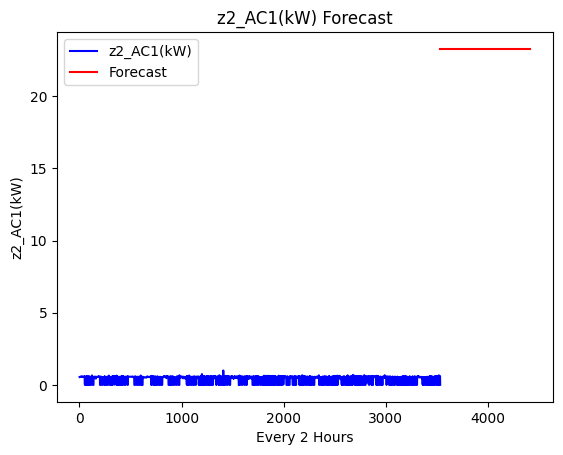

In [86]:
for column in all_forecasts:
  if column in ['z2_AC1(kW)']:
    new_column = np.concatenate([data[column][:train_size], all_forecasts[column]])
    x = np.arange(1, len(new_column) + 1)

    split_point = len(new_column) - len(forecasts)

    plt.plot(x[:split_point], new_column[:split_point], label=f'{column}', color='blue')

    plt.plot(x[split_point:], new_column[split_point:], label='Forecast', color='red')

    plt.xlabel('Every 2 Hours')
    plt.ylabel(f'{column}')
    plt.title(f'{column} Forecast')

    plt.legend()

    plt.show()